In [1]:
import time
import logging
from datetime import datetime, timezone
logging.basicConfig(level=logging.INFO)

import pytz
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

import requests
# pip install PyExecJs
import execjs

buy_window = 20
sell_window = 50
pe_percent = 0.8
cache = dict()

INFO:root:load from cache which might be stale


,x,y,baseline,buy,cost,position,value,return
2797,2021-03-03 00:00:00+08:00,1.9283,1.673581,0.0,196.966033,1.020211,302.963598,1.538151
2798,2021-03-04 00:00:00+08:00,1.8710,1.623850,1.0,196.966033,1.989895,302.933282,1.537998
2799,2021-03-05 00:00:00+08:00,1.8655,1.619077,2.0,196.966033,3.984045,302.927432,1.537968
2800,2021-03-08 00:00:00+08:00,1.8041,1.565787,2.0,196.966033,5.852917,302.796304,1.537302
2801,2021-03-09 00:00:00+08:00,1.7675,1.534022,2.0,196.966033,7.734178,302.677565,1.536699


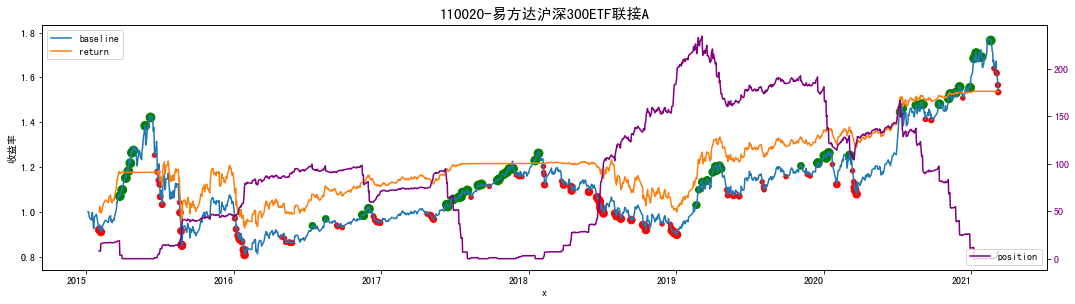

In [91]:
class Fund:
    cache = dict()
    def __init__(self, code):
        self.code = code
        self.name, self.df = Fund.download(code)

    @classmethod
    def download(cls, code):
        """get data from 天天基金"""
        if code in cache:
            logging.info('load from cache which might be stale')
            name, ACWorthTrend = cache.get(code)
        else:
            url = 'http://fund.eastmoney.com/pingzhongdata/{0}.js?v={1}'.format(code, time.strftime("%Y%m%d%H%M%S",time.localtime()))
            logging.info('download from %s' % url)
            r = requests.get(url)
            assert r.status_code == 200
            jsContent = execjs.compile(r.text)
            name = jsContent.eval('fS_name')
            ACWorthTrend = jsContent.eval('Data_ACWorthTrend')
            cache[code] = (name, ACWorthTrend)
        df = pd.DataFrame(ACWorthTrend, columns=['x', 'y'])
        df.x = pd.to_datetime(df['x'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('Asia/Shanghai')
        return name, df

    def buy_or_sell(self, worth):
        """strategy of trading"""
        l = len(worth)
        assert l > 0
        return 1 # 无脑定投

    def backtest(self, start_date=None, end_date=None):
        if start_date is None:
            start_date = self.df.iloc[0]['x']
        if end_date is None:
            end_date = self.df.iloc[-1]['x']
        # to suppress the warning: A value is trying to be set on a copy of a slice from a DataFrame.
        df = self.df.copy(deep=True)
        df = df.loc[(df.x >= start_date) & (df.x <= end_date)]
        df['baseline'] = df['y'] / df.iloc[0]['y'] # buy and hold
        df['buy'] = 0. # 买入或卖出的金额
        df['cost'] = np.nan # 成本
        df['position'] = np.nan # 持仓
        df['value'] = np.nan # 总资产 = 持仓 + 已经赎回的现金
        df['return'] = np.nan # 累计收益率 = 总资产 / 成本的极大值
        cost = 0 # 成本
        share = 0 # 份额
        money = 0 # 已经赎回的部分
        worth = df.y.tolist()
        for i, j in enumerate(df.index):
            x = self.buy_or_sell(worth[:i+1])
            df.at[j, 'buy'] = x
            y = worth[i]
            if x < 0:
                # sell
                x = -min(-x, share * y)
                money -= x
            else:
                # buy
                if x < money:
                    money -= x
                else:
                    cost += (x - money)
                    money = 0
            assert share >= -1e-6, share
            share += x/y
            position = share * y
            value = position + money
            if cost > 0:
                r = value / cost
                df.at[j, 'return'] = r
                df.at[j, 'cost'] = cost
                df.at[j, 'value'] = value
                df.at[j, 'position'] = position
        fig, ax1 = plt.subplots(figsize=(18,5))
        df.plot(x='x', y=['baseline', 'return'], ax=ax1)
        buy = df[df['buy'] > 0]
        sell = df[df['buy'] < 0]
        buy.plot(x='x', y=['baseline'], ax=ax1, kind='scatter', color='red', s=20*np.sqrt(buy['buy']))
        sell.plot(x='x', y=['baseline'], ax=ax1, kind='scatter', color='green', s=20*np.sqrt(np.absolute(sell['buy'])))
        ax1.set_ylabel('收益率')
        ax1.set_title('{0}-{1}'.format(self.code, self.name), fontsize=15)
        ax2 = ax1.twinx()
        color = 'purple'
        df.plot(x='x', y=['position'], ax=ax2, color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.legend(loc='lower right')
        return df

def strategy1(worth):
    """strategy of trading"""
    l = len(worth)
    assert l > 0
    current = worth[-1]
    rank = sorted(worth).index(current)
    # rank/l < 0.9
    if l >= buy_window:
        for k in range(8, 0, -1):
            if current == min(worth[-k * buy_window:]):
                return k
    # return 0 # 一直持有
    if l >= sell_window:
        for k in range(3, 0, -1):
            if current == max(worth[-k * buy_window * 5:]):
                return -k * 3
    return 0

def strategy2(worth):
    """strategy of trading"""
    l = len(worth)
    assert l > 0
    current = worth[-1]
    if l >= buy_window:
        for k in range(8, 0, -1):
            if current == min(worth[-k * buy_window:]):
                return k
    if l >= sell_window:
        for k in range(3, 0, -1):
            if worth[-2] == max(worth[-k * buy_window * 5:]):
                return -k * 5
    return 0



f = Fund('110020')
f.buy_or_sell = strategy2
start = pytz.timezone('Asia/Shanghai').localize(datetime(2015, 1, 1))
df100 = f.backtest(start)
df100.iloc[-5:]


In [89]:
for k,v in cache.items():
    print(k, v[0])

004746 易方达上证50增强C
008593 天弘沪深300指数增强C
005918 天弘沪深300ETF联接C
161725 招商中证白酒指数(LOF)
161005 富国天惠成长混合A/B(LOF)
502010 易方达证券公司(LOF)
008591 天弘中证全指证券公司C
001557 天弘中证500指数增强C
001593 天弘创业板ETF联接基金C
502056 广发中证医疗指数(LOF)A
006751 富国互联科技股票A
161903 万家行业优选混合(LOF)
001595 天弘中证银行ETF联接C


In [88]:
del cache['110020']

INFO:root:download from http://fund.eastmoney.com/pingzhongdata/005918.js?v=20201226215232


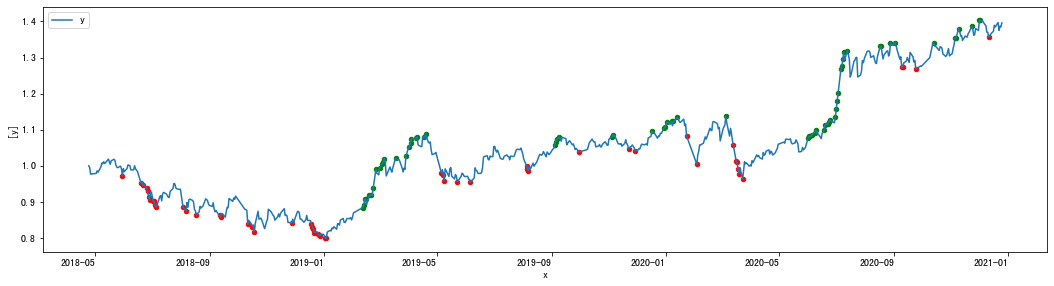

In [28]:
_, df = Fund.download('005918')
df['y_rolling_min'] = df['y'].rolling(buy_window).min()
df['y_rolling_max'] = df['y'].rolling(sell_window).max()


start = pytz.timezone('Asia/Shanghai').localize(datetime(2015, 1, 1))
df2 = df.loc[df.x >= start]
buy = df2.loc[df2['y'] == df2['y_rolling_min']]
sell = df2.loc[df2['y'] == df2['y_rolling_max']]

fig, ax = plt.subplots(figsize=(18,5))
df2.plot(x='x', y=['y'], ax=ax)
buy.plot(x='x', y=['y'], ax=ax, kind='scatter', color='red')
sell.plot(x='x', y=['y'], ax=ax, kind='scatter', color='green')
# ax.set_title(name)
